In [167]:
!ls results/cnn_large_30_stocks_w_size_50_epochs_300

In [168]:
!nvidia-smi

Wed Dec 25 01:28:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.02              Driver Version: 545.29.02    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10                     Off | 00000000:05:00.0 Off |                    0 |
|  0%   41C    P0              56W / 150W |    420MiB / 23028MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [169]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
%autoreload 2

In [171]:
# from IPython.core.display_functions import clear_output
import numpy as np
import torch
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from src.model import CNN2d, DDPG
from src.train_utils import fit_agent, agent_trading, rewards_plot
from src.stock_env import StockTradingMultipleEnv

# Подготовка данных

device = "cuda" if torch.cuda.is_available() else "cpu"

df_stocks = pd.read_csv("data/df_rus_processed.csv", index_col=0)
df_stocks['date'] = pd.to_datetime(df_stocks['date'])

In [172]:
tics, prices = df_stocks[df_stocks['date'] == df_stocks['date'].unique()[0]][['tic', 'close']].values.T

In [173]:
stock_list_30 = []
for tic, price in sorted(dict(zip(list(tics), list(prices))).items(), key=lambda x: x[1], reverse=True)[11:-8]:
    stock_list_30.append((tic, price))
stock_list_30

[('HHRU', 3424.0),
 ('YNDX', 2500.6),
 ('MGTS', 2130.0),
 ('BANE', 1899.5),
 ('NVTK', 1642.8),
 ('CHMF', 1297.2),
 ('AGRO', 1197.2),
 ('PIKK', 776.0),
 ('KAZT', 753.6),
 ('MOEX.LENT:TQBR', 745.5),
 ('SIBN', 658.65),
 ('TATN', 602.8),
 ('ROSN', 557.05),
 ('ENPG', 502.8),
 ('MOEX.FIXP:TQBR', 399.2),
 ('RASP', 346.85),
 ('MTSS', 277.3),
 ('SBER', 259.88),
 ('KMAZ', 244.0),
 ('NLMK', 192.18),
 ('GAZP', 173.7),
 ('MOEX', 170.35),
 ('NKNC', 132.0),
 ('KZOS', 119.8),
 ('MOEX.FLOT:TQBR', 107.11),
 ('FESH', 100.06),
 ('ALRS', 78.08),
 ('RTKM', 74.6),
 ('MAGN', 51.76),
 ('SNGSP', 48.345)]

In [174]:
tic = 'CHMF'
TRAIN_END_DATE_rus = pd.to_datetime('2023-10-17 18:40')
VAL_END_DATE_rus = pd.to_datetime('2023-10-19 18:40')
TEST_END_DATE_rus = pd.to_datetime('2023-10-23 18:40')


def single_stock_split(df_stocks, tic):
    df_stock_train = df_stocks[(df_stocks['tic'] == tic) & (df_stocks['date'] < TRAIN_END_DATE_rus)]
    df_stock_val = df_stocks[
        (df_stocks['tic'] == tic) & (df_stocks['date'] >= TRAIN_END_DATE_rus) & (df_stocks['date'] < VAL_END_DATE_rus)]
    df_stock_test = df_stocks[
        (df_stocks['tic'] == tic) & (df_stocks['date'] >= VAL_END_DATE_rus) & (df_stocks['date'] < TEST_END_DATE_rus)]
    train_values = df_stock_train['close'].values
    val_values = df_stock_val['close'].values
    test_values = df_stock_test['close'].values

    print(f"train size: {len(train_values)}, val_size: {len(val_values)}, test_size: {len(test_values)}")
    plt.plot(df_stock_train.index, train_values, color='blue')
    plt.plot(df_stock_val.index, val_values, color='green')
    plt.plot(df_stock_test.index, test_values, color='orange')
    plt.show()

    return df_stock_train, df_stock_val, df_stock_test


def multiple_stock_split(df_stocks, stock_list):
    df_prices = df_stocks[df_stocks['tic'].isin(stock_list)]
    df = pd.DataFrame(df_prices['close'].values.reshape(-1, len(stock_list)), columns=stock_list)
    df['date'] = df_prices['date'].unique()

    df_stock_train = df[df['date'] < TRAIN_END_DATE_rus]
    df_stock_val = df[(df['date'] >= TRAIN_END_DATE_rus) & (df['date'] < VAL_END_DATE_rus)]
    df_stock_test = df[(df['date'] >= VAL_END_DATE_rus) & (df['date'] < TEST_END_DATE_rus)]
    print(f"train size: {len(df_stock_train)}, val_size: {len(df_stock_val)}, test_size: {len(df_stock_test)}")

    return df_stock_train, df_stock_val, df_stock_test


stock_list = ['AGRO', 'ALRS', 'BANE', 'CBOM', 'CHMF', 'ENPG', 'FEES', 'FESH', 'GAZP', 'HHRU']
# stock_list = ['AGRO', 'BANE', 'CHMF', 'ENPG', 'GAZP']
# stock_list = list(list(zip(*stock_list_30))[0])[:25]
df_stock_train, df_stock_val, df_stock_test = multiple_stock_split(df_stocks, stock_list)

train size: 11959, val_size: 1040, test_size: 1040


In [175]:
df_stock_train

,AGRO,ALRS,BANE,CBOM,CHMF,ENPG,FEES,FESH,GAZP,HHRU,date
0,1197.2,78.08,1899.5,6.761,1297.2,502.8,0.12414,100.06,173.70,3424.0,2023-09-15 10:01:00
1,1201.2,77.90,1898.0,6.767,1296.4,503.6,0.12426,101.60,173.70,3433.0,2023-09-15 10:02:00
2,1203.6,77.74,1899.0,6.765,1293.0,503.0,0.12314,101.69,173.64,3423.0,2023-09-15 10:03:00
3,1207.4,77.82,1917.0,6.766,1294.2,503.6,0.12340,101.75,173.64,3424.0,2023-09-15 10:04:00
4,1204.2,77.80,1910.5,6.765,1292.2,503.6,0.12340,100.92,173.62,3427.0,2023-09-15 10:05:00
...,...,...,...,...,...,...,...,...,...,...,...
11954,1371.0,77.20,2041.0,7.152,1422.6,516.2,0.11916,98.38,172.10,3832.0,2023-10-17 18:35:00
11955,1371.0,77.19,2040.5,7.152,1422.8,515.4,0.11922,98.34,171.75,3832.0,2023-10-17 18:36:00
11956,1370.6,77.18,2040.0,7.152,1422.6,516.4,0.11928,98.38,171.93,3831.0,2023-10-17 18:37:00
11957,1370.4,77.25,2040.0,7.143,1422.0,516.8,0.11930,98.35,172.00,3830.0,2023-10-17 18:38:00


In [176]:
n_splits = (300, 300, 300)
n_train, n_val, n_test = n_splits
w_size = 50
stocks_max = 20

if n_splits is not None:
    x_train = df_stock_train.iloc[:n_train]
    x_val = df_stock_train.iloc[n_train: n_train + n_val]
    x_test = df_stock_train.iloc[n_train + n_val: n_train + n_val + n_test]
else:
    x_train = df_stock_train
    x_val = df_stock_val
    x_test = df_stock_test

env_kwargs_common = {
    'initial_amount': 1e8,
    'reward_scaling': 1e-8,
    'stock_list': stock_list,
    'window_size': w_size,
    'hmax': stocks_max,
}

env_stock_train = StockTradingMultipleEnv(
    **env_kwargs_common,
    env_name='train',
    data=x_train,
)
state = env_stock_train.reset()
print(state, '\n')

env_stock_val = StockTradingMultipleEnv(
    **env_kwargs_common,
    env_name='val',
    data=x_val,
)
state_val = env_stock_val.reset()
print(state_val, '\n')

env_stock_test = StockTradingMultipleEnv(
    **env_kwargs_common,
    env_name='test',
    data=x_test,
)
state_test = env_stock_test.reset()
print(state_test, '\n')

[[1211.4, 77.86, 1937.0, 6.765, 1288.8, 502.0, 0.1242, 104.66, 173.81, 3431.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 100000000.0, 100000000.0] 

[[1214.0, 77.3, 1955.0, 6.828, 1305.6, 516.6, 0.12632, 105.04, 173.95, 3452.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 100000000.0, 100000000.0] 

[[1232.0, 75.39, 1967.5, 6.84, 1309.0, 520.2, 0.12578, 103.85, 173.81, 3529.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 100000000.0, 100000000.0] 



In [177]:
logging = True
episode_n = 300
w_size = 50
study_name = f'cnn_large_{len(stock_list)}_stocks_w_size_{w_size}_epochs_{episode_n}'

if logging:
    for i in ['results']:
        if os.path.exists(f'{i}/{study_name}'):
            #raise ValueError(f"folder {i}/{study_name} already exists!")
            print(f'warning: path {i}/{study_name} exists!')
        else:
            os.makedirs(f'{i}/{study_name}')

In [178]:
#CNN
policy_kwargs = {'dim_list': [512, 256], 'output_dim': len(stock_list)}
policy_type = 'cnn'
policy = CNN2d
state_dim = w_size

ddpg_agent = DDPG(policy=policy, policy_type=policy_type, kwargs=policy_kwargs, multiple_stocks=True,
                  state_dim=state_dim, device=device, action_dim=1, action_max=1, batch_size=128, noise_decrease=1e-3)

total_train_rewards, total_val_rewards = [], []
best_val_reward = None
agent_actions = {}

  0%|          | 0/100 [00:00<?, ?it/s]

break
break
break
break
break
break
break
break
break
break
(episode + 1) % 10 = 0


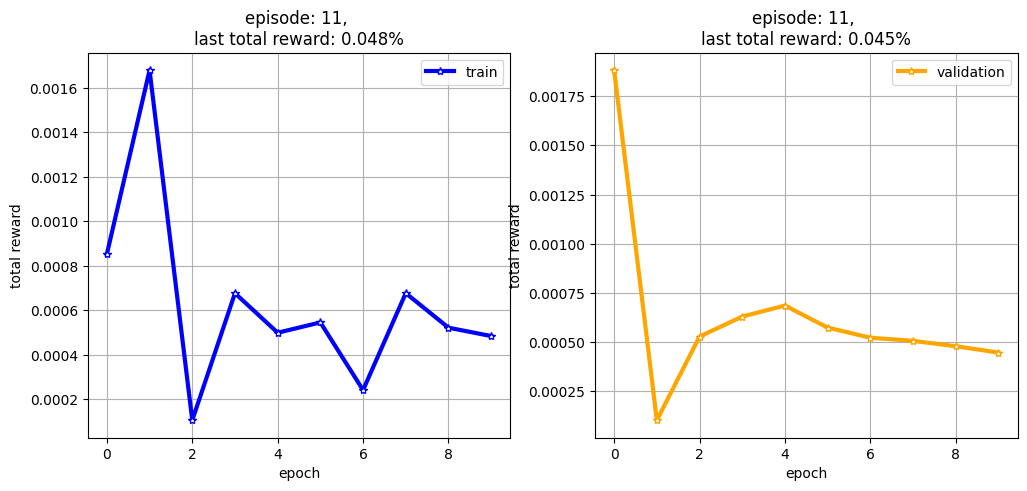

break
break
break
break
break
break
break
break
break
break
(episode + 1) % 10 = 0


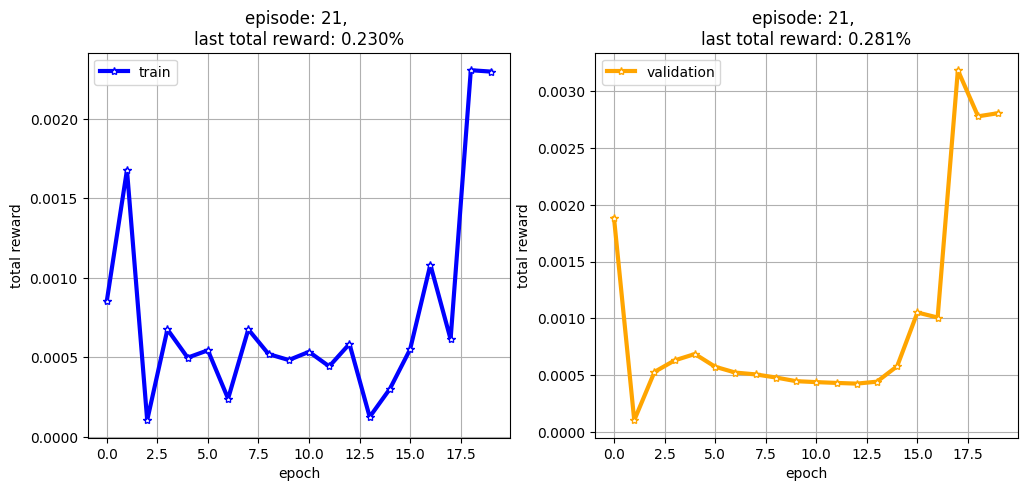

break
/home/ubuntu/project-rl-mai/DDPG_agent/cnn_large_10_stocks_w_size_50_epochs_300/pi_model.pkl
break
break
break
/home/ubuntu/project-rl-mai/DDPG_agent/cnn_large_10_stocks_w_size_50_epochs_300/pi_model.pkl
break
/home/ubuntu/project-rl-mai/DDPG_agent/cnn_large_10_stocks_w_size_50_epochs_300/pi_model.pkl
break
break
/home/ubuntu/project-rl-mai/DDPG_agent/cnn_large_10_stocks_w_size_50_epochs_300/pi_model.pkl
break
/home/ubuntu/project-rl-mai/DDPG_agent/cnn_large_10_stocks_w_size_50_epochs_300/pi_model.pkl
break
break
(episode + 1) % 10 = 0


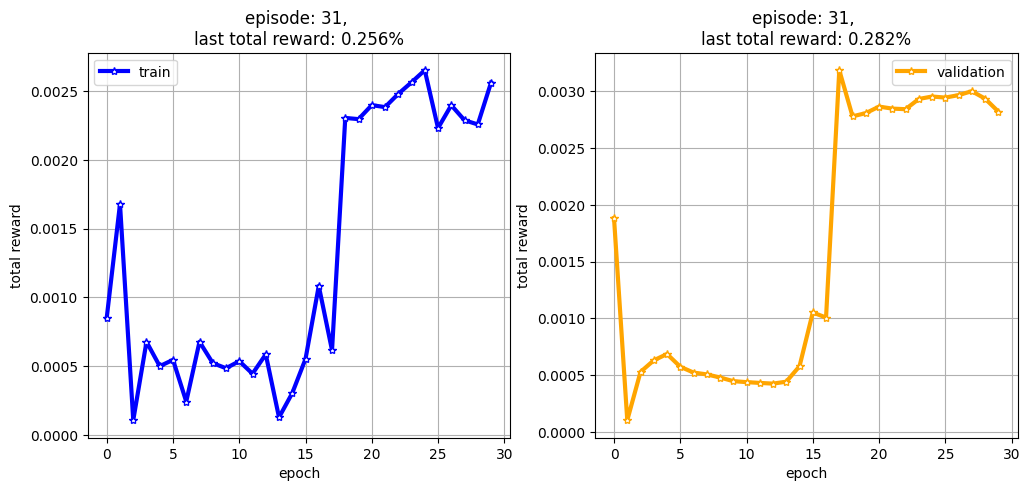

break
break
break
break
break
break
break
break
break
break
(episode + 1) % 10 = 0


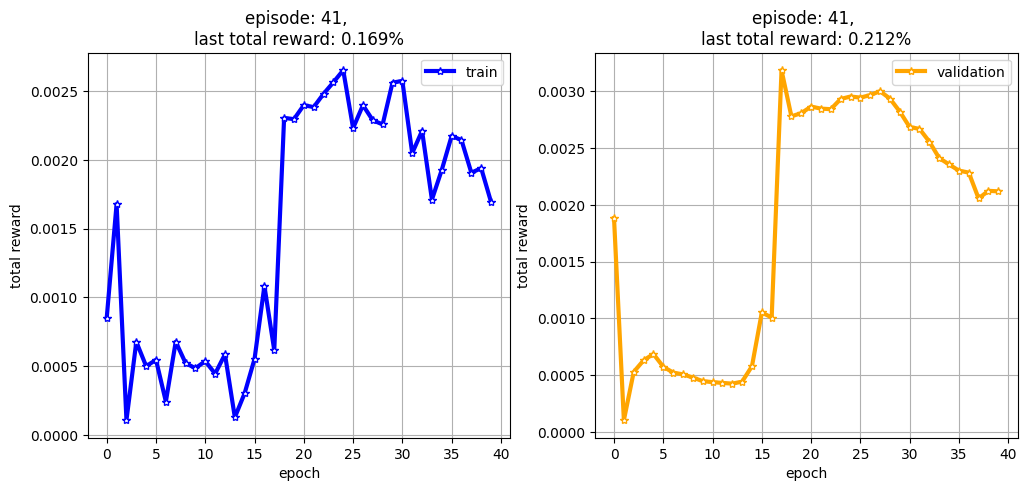

break
break
break
break
break
break
break
break
break
break
(episode + 1) % 10 = 0


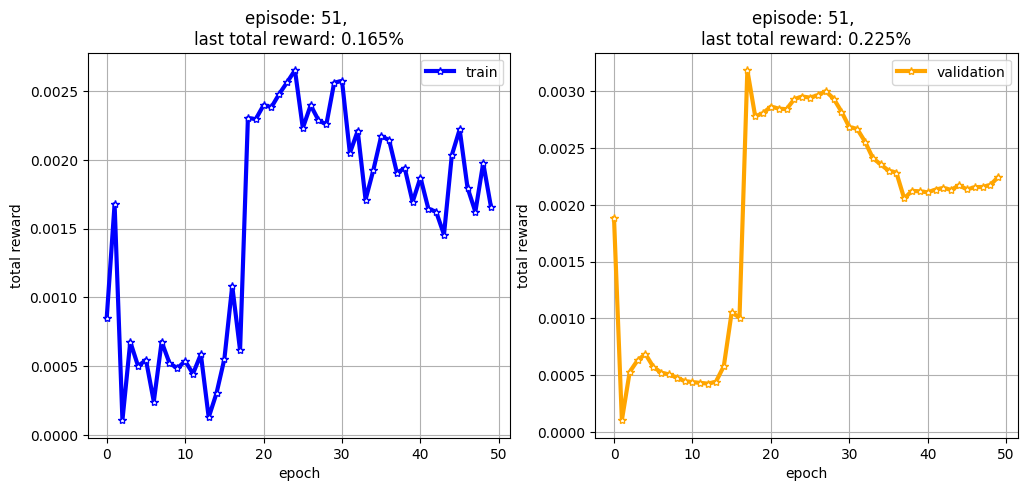

break
break
break
break
break
break


KeyboardInterrupt: 

In [179]:
for episode in tqdm(range(100)):
    total_reward_train = fit_agent(ddpg_agent, env_stock_train, stock_list=stock_list, w_size=w_size)
    total_train_rewards.append(total_reward_train)

    total_reward_val = agent_trading(ddpg_agent, env_stock_train, stock_list=stock_list, w_size=w_size)
    total_val_rewards.append(total_reward_val)

    if best_val_reward is None:
        best_val_reward = total_reward_val
    else:
        if (total_reward_val >= best_val_reward) & (episode >= 20):
            best_val_reward = total_reward_val
            if logging:
                ddpg_agent.save(dir=f'DDPG_agent/{study_name}')

    # clear_output(True)
    if (episode + 1) % 10 == 0:
        print(f"(episode + 1) % 10 = {(episode + 1) % 10}")
        rewards_plot(total_train_rewards, total_val_rewards,
                     save=episode == (episode_n - 1), path=f'results/{study_name}/rewards_plot.png')

total_reward_test = agent_trading(ddpg_agent, env_stock_train, stock_list=stock_list, w_size=w_size)
print("total test reward for last model: {:.3f}%".format(total_reward_test * 100))

In [ ]:
ddpg_agent.save(dir='DDPG_agent/cnn_30_stocks_train_2000_w_size_50_epochs_300')

In [ ]:
plt.figure(figsize=(20, 5))
plt.title(f'actions by each stock distribution: \nDDPG, policy type: {policy_type}:')
plt.hist(np.array(env_stock_train.actions_buffer))
plt.show()

In [ ]:
print(env_stock_train.state_story[-1])

In [ ]:
plt.plot(env_stock_train.portfolio_size_story)
plt.show()